# __Finite element analysis and machine learning to predict mechanical properties of polydisperse fiberous composites__

*Ian Johnston*

This notebook describes the generation of dataset, dimension reduction, pseudo-FEA data generation, PCA, and ML model training and testing. This work considers 3 different fiber distribution cases:

1. monodisperse fibers (part 1)
2. unimodal, normally distributed fibers (part 2)
3. bimodal, with two normal distributions superimposed (part 3)

__caution__
This notebook was executed on a relatively high performance computer. It is runnable on a laptop by reducing the number of microstructures generated by changing the parameter n

In [51]:
# load packages

#basic ones
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import time
import seaborn as sns
# Image handling
import cv2 as cv

#2-point corralation function
from pymks.stats import correlate
from pymks import PrimitiveBasis
from pymks.tools import draw_correlations
from pymks.datasets import make_microstructure
from pymks.tools import draw_microstructures

# Sklearn packages
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor


#sklearn packages - metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# __Part 1__
## Generation of monodisperse composites

In [52]:
#number of cross-sections generated per fill ratio
n = 400

# This is the fractional fill ratio of fiber in the composite
fill_list = [0.1, 0.2, 0.30, 0.40, 0.50]

#Generate empty array for composite cross-sections
output_images = np.empty((400, 400, n*len(fill_list)))

m = 0
t1 = time.time()
for a, f in enumerate(fill_list):
    
    for i in range(n):
        
        #temporary array to populate with circles
        base = np.zeros([400, 400])
        fill = f
        radius = 50
                
        #determine how many circles need to be plotted to reach the target fill ratio
        area_total = base.shape[0] * base.shape[1]
        n_circles = (fill * area_total) / (3.141 * radius **2)
        n_circles = int(n_circles)

        actual_ratio = (n_circles * 3.141 * radius **2) / area_total

        # code borrow and modified from
        # https://stackoverflow.com/questions/46702987/python-pygame-randomly-draw-non-overlapping-circles?noredirect=1&lq=1

        class circle_class():
            def __init__(self):
                self.x = np.random.randint(0,base.shape[0])
                self.y = np.random.randint(0,base.shape[1])
                self.r = radius

            def new(self):
                #draws a circle of value 1 on the empty array
                cv.circle(base, (self.x, self.y), self.r, color = 1, thickness = -1)


        counter = 1
        circles = []
        
        #while number of cirlces drawn is less than the number of circles needed:
        while len(circles) < n_circles:
            # Draw a new circle
            new = circle_class()
            
            #keeps making new circles until the condition below is violated
            if any(pow(c.r - new.r, 2) <= \
                   pow(c.x - new.x, 2) + pow(c.y - new.y, 2) <= \
                   pow(c.r + new.r, 2) \
                for c in circles):

                    continue


            circles.append(new)
            new.new()
        
        
        #populate output array with temporary array
        output_images[:, :, m] = base
        
        m += 1
t2 = time.time()
print('Time per step [ms] %.2f:' %((t2 - t1)*1000))

Time per step [ms] 4709.77:


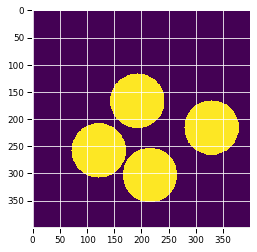

In [53]:
plt.imshow(output_images[:, :, 480])

# __Part 1__
## 2D Coordinate Representation work

Convert Binary image into the 2-point coordinate map

In [54]:
t1 = time.time()
#Set up correlation function
p_basis = PrimitiveBasis(n_states=2, domain=[0, 1])
#set up output array
corr_images = np.empty((400, 400, n*len(fill_list)))

#add a new axis to the output images array to make the correlation function happy
input_array = output_images[np.newaxis, :, :, :]

#feed input array through correlate function, select the first element of axis 3, which is the fiber to fiber correlation
for i in range(n*len(fill_list)): 
    
    corr_images[:, :, i] = correlate(input_array[:, :, :, i], p_basis, periodic_axes = [0, 1])[0, :, :, 0]
t2 = time.time()
print('Time per step [ms] %.2f:' %((t2 - t1)*1000))

Time per step [ms] 122699.69:


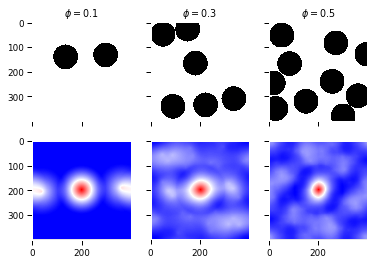

In [55]:
# figure 1
'''
Plot several fiber cross sections
'''
fig, ax = plt.subplots(2,3)

ax4 = plt.subplot(234)
plt.imshow(corr_images[:, :, 1], cmap = 'bwr')
ax4.grid(False)

ax1 = plt.subplot(231, sharey=ax4)
plt.imshow(output_images[:, :, 1], cmap = 'Greys')
plt.setp(ax1.get_xticklabels(), visible=False)
ax1.grid(False)

# share x and y
ax2 = plt.subplot(232, sharey=ax4, sharex = ax1)
plt.imshow(output_images[:, :, 801], cmap = 'Greys')
plt.setp(ax2.get_xticklabels(), visible=False)
plt.setp(ax2.get_yticklabels(), visible=False)
ax2.grid(False)

# share x and y
ax3 = plt.subplot(233, sharey=ax4, sharex = ax1)
plt.imshow(output_images[:, :, 1601], cmap = 'Greys')
plt.setp(ax3.get_xticklabels(), visible=False)
plt.setp(ax3.get_yticklabels(), visible=False)
ax3.grid(False)



# share x and y
ax5 = plt.subplot(235, sharey=ax4, sharex = ax1)
plt.imshow(corr_images[:, :, 801], cmap = 'bwr')
plt.setp(ax5.get_yticklabels(), visible=False)
ax5.grid(False)

# share x and y
ax6 = plt.subplot(236, sharey=ax4, sharex = ax1)
plt.imshow(corr_images[:, :, 1601], cmap = 'bwr')
plt.setp(ax6.get_yticklabels(), visible=False)
ax6.grid(False)


ax1.set_title('$\phi =0.1$')
ax2.set_title('$\phi =0.3$')
ax3.set_title('$\phi =0.5$')

#fig.colorbar(plt.imshow(output_images[:, :, 1601], cmap = 'Greys'), ax=ax3, location='right', shrink=0.6)
#fig.colorbar(plt.imshow(corr_images[:, :, 1601], cmap = 'bwr'), ax=ax6, location='right', shrink=0.6)

plt.savefig('fibers_2point.jpeg', dpi = 600)

# __Part 1__
## Flatten image stack and reshape array

In [56]:
'''
order F is fortan order with first index changing the fastest, since index 2 is image number, it should change last.


''' 
t1 = time.time()
X_data = np.reshape(corr_images, (n*len(fill_list), 160000), order = 'F')
t2 = time.time()

print('Time per step [ms] %.2f:' %((t2 - t1)*1000))

Time per step [ms] 4238.74:


# __Part 1__
## Pseudo-FEA Data Generation

While the original publication uses the finite element analysis software Abaqus to generate expected material properties, the learning curve to get this piece of software functional and ready for scripting is just too high for the length of time available. Instead, simulated data will be generated instead. Examining the publication, the predicted mechanical properties have a very strong linear dependence on % fiber loading. As such, it will be possible to simulate data based on that. To further add robustness to the study, a number of underlying trends will be modeled

In [58]:
t1 = time.time()

#initialize list
y = np.empty((X_data.shape[0], 6))

#fill list with mean values
for i in range(n*len(fill_list)):
    
    # convert mean fill % to E sub 22 values in GPa
    y[i, 0] = output_images[:, :, i].mean()*20
   
    # generate noise
    y[i, 1] = np.random.normal(0, 1)

# Combine noise and percent fill together
y[:, 2] = y[:, 0] + y[:, 1]

# add underlying trends
#log
y[:, 3] = np.absolute(np.log(y[:, 2]*10)*10)

#quadratic
y[:, 4] = -(y[:, 2])*(y[:, 2]-2)*20

#quartic
y[:, 5] = -70*y[:, 2]*(y[:, 2]-1.1)*((y[:, 2]+0.2))*(y[:, 2]+0.4)**2

#clean up possible nan values from the log function
y = np.nan_to_num(y, nan = 0)

t2 = time.time()

print('Time per step [ms] %.2f:' %((t2 - t1)*1000))

Time per step [ms] 2727.13:


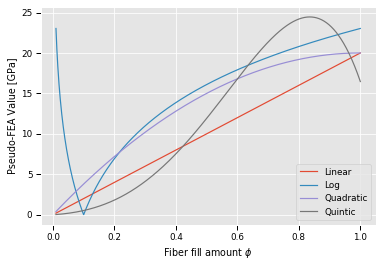

In [60]:
'''
Make figure for the paper showing the shape of all the distributions
'''

x = np.linspace(0.01, 1, 1000)
y1 = x*20
y2 = np.absolute(np.log(x*10)*10)
y3 = -(x)*(x-2)*20
y4 = -70*x*(x-1.1)*((x+0.2))*(x+0.4)**2

labels = ['Linear', 'Log', 'Quadratic', 'Quintic']

sns.set_context('paper')
fig, ax = plt.subplots(1, 1)

sns.lineplot(x = x, y = y1, ax =ax)
sns.lineplot(x = x, y = y2, ax =ax)
sns.lineplot(x = x, y = y3, ax =ax)
sns.lineplot(x = x, y = y4, ax =ax)

ax.set_ylabel('Pseudo-FEA Value [GPa]')
ax.set_xlabel('Fiber fill amount $\phi$')
plt.legend(labels)

plt.savefig('underlying_functions.png', dpi = 600)

# __Part 1__
## Machine Learning Work
This code block contains the train/test split, PCA algorithm, the Gradient Boosting Regressor. The parameters for the Gradient Boosted Tree Regressor was adopted by directly from the original publication without modification.


In [61]:
n_PC = [2, 5, 10, 25, 50]
FEA_models = [0, 2, 3, 4, 5]

results_time = np.zeros((5, 5))
results_train_MAE = np.zeros((5, 5))
results_test_MAE = np.zeros((5, 5))

results_train_r2 = np.zeros((5, 5))
results_test_r2 = np.zeros((5, 5))


for b, PCs in enumerate(n_PC):
    t1 = time.time()
    
    '''
    perform PCA on n components and fit the x data to this
    
    '''
    x_pca = PCA(n_components = PCs).fit_transform(X_data)
    
    t2 = time.time()
    for a, model in enumerate(FEA_models):
        t3 = time.time()
        print(b, a)    
        #select one column
        y_vars = y[:, model]

        #train/test split
        x_train_pca, x_test_pca, y_train, y_test = train_test_split(x_pca, y_vars, test_size = 0.25)
             
        
        print('time for PCA', (t2-t1))
        
        #define model and fit data. These parameters are from the original paper
        params = {'n_estimators': 800,
          'max_depth': 3,
          'learning_rate': 0.1}
        
        reg = GradientBoostingRegressor(**params)
        reg.fit(x_train_pca, y_train)

               
        #get y_predictions
        y_train_pred = reg.predict(x_train_pca)
        y_test_pred = reg.predict(x_test_pca)
        
        #Time per loop
        t4 = time.time()
        
        
        #Save results    
        results_time[b, a] = (t2-t1 + t4-t3)
        
        results_train_MAE[b, a] = mean_absolute_error(y_train, y_train_pred)
        results_test_MAE[b, a] = mean_absolute_error(y_test, y_test_pred)
        
        results_train_r2[b, a] = r2_score(y_train, y_train_pred)
        results_test_r2[b, a] = r2_score(y_test, y_test_pred)
        
        
        '''
        For diagnostics, add a plot of the true vs predicted y values
        '''
        
        fig, ax = plt.subplots(1,2, figsize = (10, 4))

        sns.scatterplot(x = y_train, y = y_train_pred, ax = ax[0])
        sns.scatterplot(x = y_test, y = y_test_pred, ax = ax[1])

        ax[0].set_title('Y train vs Y Train Predicted')
        ax[1].set_title('Y test vs Y Test Predicted')

        ax[0].set_xlabel('FEA Predictions')
        ax[1].set_xlabel('FEA Predictions')

        ax[0].set_ylabel('ML Predictions')
        ax[1].set_ylabel('ML Predictions')
        
        plt.suptitle('N of PCs:'+str(PCs)+ ' | Underlying model:' + str(model) )

        plt.savefig('N of PCs'+str(PCs)+ '  Underlying model' + str(model)+'nm.jpeg')

        plt.close()

0 0
time for PCA 6.013948202133179
0 1
time for PCA 6.013948202133179
0 2
time for PCA 6.013948202133179
0 3
time for PCA 6.013948202133179
0 4
time for PCA 6.013948202133179
1 0
time for PCA 6.364229917526245
1 1
time for PCA 6.364229917526245
1 2
time for PCA 6.364229917526245
1 3
time for PCA 6.364229917526245
1 4
time for PCA 6.364229917526245
2 0
time for PCA 6.680725574493408
2 1
time for PCA 6.680725574493408
2 2
time for PCA 6.680725574493408
2 3
time for PCA 6.680725574493408
2 4
time for PCA 6.680725574493408
3 0
time for PCA 7.5028886795043945
3 1
time for PCA 7.5028886795043945
3 2
time for PCA 7.5028886795043945
3 3
time for PCA 7.5028886795043945
3 4
time for PCA 7.5028886795043945
4 0
time for PCA 9.305341005325317
4 1
time for PCA 9.305341005325317
4 2
time for PCA 9.305341005325317
4 3
time for PCA 9.305341005325317
4 4
time for PCA 9.305341005325317


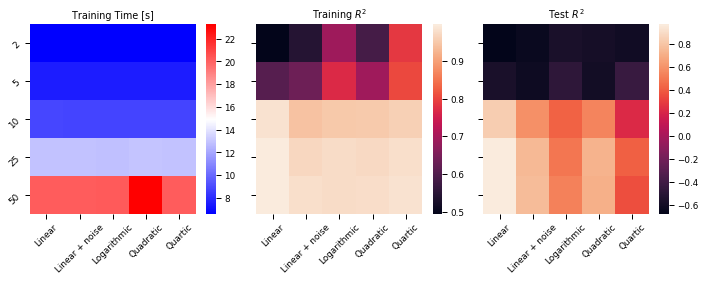

In [63]:
'''
Plot the results from the ML code block
'''

sns.set_context('paper', rc = {'Sans-Serif':'Helvetica-Neue'})

fig, ax = plt.subplots(1, 3, figsize = (10, 4))

Number_of_PCs = ["2", '5', '10', '25', '50']
FEA_Result = ["Linear", "Linear + noise", "Logarithmic",
           "Quadratic", "Quartic"]

sns.heatmap(results_time, ax = ax[0], cmap = 'bwr')
sns.heatmap(results_train_r2, ax = ax[1])
sns.heatmap(results_test_r2, ax = ax[2])



ax[0].set_xticklabels(labels = FEA_Result, rotation = 45)
ax[1].set_xticklabels(labels = FEA_Result, rotation = 45)
ax[2].set_xticklabels(labels = FEA_Result, rotation = 45)



ax[0].set_yticklabels(labels = Number_of_PCs, rotation = 45)
plt.setp(ax[1].get_yticklabels(), visible=False)
plt.setp(ax[2].get_yticklabels(), visible=False)

ax[0].set_title('Training Time [s]')
ax[1].set_title('Training $R^2$')
ax[2].set_title('Test $R^2$')


plt.tight_layout()

plt.savefig('ML results_normal.jpeg', dpi = 600)

# __Part 2__
## Unimodal, normally distributed fibers

In this section, we developed a number of composite structures that depart from the previously demonstrated work.

In [64]:
#number of cross-sections generated per fill ratio
n = 400

# This is the fractional fill ratio of fiber in the composite
fill_list = [0.1, 0.2, 0.30, 0.40, 0.50]

#Generate empty array for composite cross-sections
output_images = np.empty((400, 400, n*len(fill_list)))

m =0

for a, f in enumerate(fill_list):
    
    for i in range(n):
        t1 = time.time()
        #temporary array to populate with circles
        base = np.zeros([400, 400])
        fill = f
        
        # code borrow and modified from
        # https://stackoverflow.com/questions/46702987/python-pygame-randomly-draw-non-overlapping-circles?noredirect=1&lq=1

        class circle_class():
            def __init__(self):
                self.x = np.random.randint(0,base.shape[0])
                self.y = np.random.randint(0,base.shape[1])
                self.r = np.asscalar(np.absolute(np.random.normal(50, 15, 1)).astype(int))

            def new(self):
                #draws a circle of value 1 on the empty array
                cv.circle(base, (self.x, self.y), self.r, color = 1, thickness = -1)


        
        circles = []
        area_circle = 0
        
        '''
        The big change is that since there is a distribution, lots of really small circles could be generated, meeting the number of circles requirement, but not the area requirement
        So the while condition is changed from number to area
        
        '''
        while area_circle < f:
            # Draw a new circle
            new = circle_class()
            
            #keeps making new circles until the condition below is violated
            if any(pow(c.r - new.r, 2) <= \
                   pow(c.x - new.x, 2) + pow(c.y - new.y, 2) <= \
                   pow(c.r + new.r, 2) \
                for c in circles):

                    continue
            
            circles.append(new)
            new.new()
            
            area_circle = base.sum()/160000
            
        t2 = time.time()
        #print('Time per loop [ms] %.2f:' %((t2 - t1)*1000))
        
        #populate output array with temporary array
        output_images[:, :, m] = base
        
        m += 1

# __Part 2__
## 2-point Correlation function determination

In [65]:
t1 = time.time()
#Set up correlation function
p_basis = PrimitiveBasis(n_states=2, domain=[0, 1])
#set up output array
corr_images = np.empty((400, 400, n*len(fill_list)))

#add a new axis to the output images array to make the correlation function happy
input_array = output_images[np.newaxis, :, :, :]

#feed input array through correlate function, select the first element of axis 3, which is the fiber to fiber correlation
for i in range(n*len(fill_list)): 
    
    corr_images[:, :, i] = correlate(input_array[:, :, :, i], p_basis, periodic_axes = [0, 1])[0, :, :, 0]
t2 = time.time()
print('Time per step [ms] %.2f:' %((t2 - t1)*1000))

Time per step [ms] 123013.82:


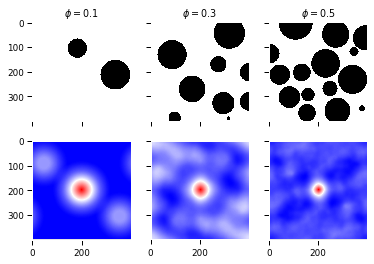

In [66]:
# figure 1
'''
Plot several fiber cross sections
'''
fig, ax = plt.subplots(2,3)

ax1 = plt.subplot(231, sharey=ax4)
plt.imshow(output_images[:, :, 1], cmap = 'Greys')
plt.setp(ax1.get_xticklabels(), visible=False)
ax1.grid(False)

# share x and y
ax2 = plt.subplot(232, sharey=ax4, sharex = ax1)
plt.imshow(output_images[:, :, 801], cmap = 'Greys')
plt.setp(ax2.get_xticklabels(), visible=False)
plt.setp(ax2.get_yticklabels(), visible=False)
ax2.grid(False)

# share x and y
ax3 = plt.subplot(233, sharey=ax4, sharex = ax1)
plt.imshow(output_images[:, :, 1601], cmap = 'Greys')
plt.setp(ax3.get_xticklabels(), visible=False)
plt.setp(ax3.get_yticklabels(), visible=False)
ax3.grid(False)

ax4 = plt.subplot(234)
plt.imshow(corr_images[:, :, 1], cmap = 'bwr')
ax4.grid(False)

# share x and y
ax5 = plt.subplot(235, sharey=ax4, sharex = ax1)
plt.imshow(corr_images[:, :, 801], cmap = 'bwr')
plt.setp(ax5.get_yticklabels(), visible=False)
ax5.grid(False)

# share x and y
ax6 = plt.subplot(236, sharey=ax4, sharex = ax1)
plt.imshow(corr_images[:, :, 1601], cmap = 'bwr')
plt.setp(ax6.get_yticklabels(), visible=False)
ax6.grid(False)


ax1.set_title('$\phi =0.1$')
ax2.set_title('$\phi =0.3$')
ax3.set_title('$\phi =0.5$')

plt.savefig('fibers_2point_pd.jpeg', dpi = 600)

# __Part 2__
## Flatten image stack

In [67]:
'''
order F is fortan order with first index changing the fastest, since index 2 is image number, it should change last.


''' 
t1 = time.time()
X_data = np.reshape(corr_images, (n*len(fill_list), 160000), order = 'F')
t2 = time.time()

print('Time per step [ms] %.2f:' %((t2 - t1)*1000))

Time per step [ms] 4237.46:


# __Part 2__
## Generation of pseudo-FEA Data

In [68]:
t1 = time.time()

#initialize list
y = np.empty((X_data.shape[0], 6))

#fill list with mean values
for i in range(n*len(fill_list)):
    
    # convert mean fill % to E sub 22 values in GPa
    y[i, 0] = output_images[:, :, i].mean()*20
   
    # generate noise
    y[i, 1] = np.random.normal(0, 1)

# Combine noise and percent fill together
y[:, 2] = y[:, 0] + y[:, 1]

# add underlying trends
#log
y[:, 3] = np.absolute(np.log(y[:, 2]*10)*10)

#quadratic
y[:, 4] = -(y[:, 2])*(y[:, 2]-2)*20

#quartic
y[:, 5] = -70*y[:, 2]*(y[:, 2]-1.1)*((y[:, 2]+0.2))*(y[:, 2]+0.4)**2

#clean up possible nan values from the log function
y = np.nan_to_num(y, nan = 0)

t2 = time.time()

print('Time per step [ms] %.2f:' %((t2 - t1)*1000))

Time per step [ms] 2602.19:


# __Part 2__
## PCA, train/test split, ML

In [69]:
n_PC = [2, 5, 10, 25, 50]
FEA_models = [0, 2, 3, 4, 5]

results_time = np.zeros((5, 5))
results_train_MAE = np.zeros((5, 5))
results_test_MAE = np.zeros((5, 5))

results_train_r2 = np.zeros((5, 5))
results_test_r2 = np.zeros((5, 5))


for b, PCs in enumerate(n_PC):
    t1 = time.time()
    
    '''
    perform PCA on n components and fit the x data to this
    
    '''
    x_pca = PCA(n_components = PCs).fit_transform(X_data)
    
    t2 = time.time()
    for a, model in enumerate(FEA_models):
        t3 = time.time()
        print(b, a)    
        #select one column
        y_vars = y[:, model]

        #train/test split
        x_train_pca, x_test_pca, y_train, y_test = train_test_split(x_pca, y_vars, test_size = 0.25)
             
        
        print('time for PCA', (t2-t1))
        
        #define model and fit data. These parameters are from the original paper
        params = {'n_estimators': 800,
          'max_depth': 3,
          'learning_rate': 0.1}
        
        reg = GradientBoostingRegressor(**params)
        reg.fit(x_train_pca, y_train)

               
        #get y_predictions
        y_train_pred = reg.predict(x_train_pca)
        y_test_pred = reg.predict(x_test_pca)
        
        #Time per loop
        t4 = time.time()
        
        
        #Save results    
        results_time[b, a] = (t2-t1 + t4-t3)
        
        results_train_MAE[b, a] = mean_absolute_error(y_train, y_train_pred)
        results_test_MAE[b, a] = mean_absolute_error(y_test, y_test_pred)
        
        results_train_r2[b, a] = r2_score(y_train, y_train_pred)
        results_test_r2[b, a] = r2_score(y_test, y_test_pred)
        
        
        '''
        For diagnostics, add a plot of the true vs predicted y values
        '''
        
        fig, ax = plt.subplots(1,2, figsize = (10, 4))

        sns.scatterplot(x = y_train, y = y_train_pred, ax = ax[0])
        sns.scatterplot(x = y_test, y = y_test_pred, ax = ax[1])

        ax[0].set_title('Y train vs Y Train Predicted')
        ax[1].set_title('Y test vs Y Test Predicted')

        ax[0].set_xlabel('FEA Predictions')
        ax[1].set_xlabel('FEA Predictions')

        ax[0].set_ylabel('ML Predictions')
        ax[1].set_ylabel('ML Predictions')
        
        plt.suptitle('N of PCs:'+str(PCs)+ ' | Underlying model:' + str(model) )

        plt.savefig('N of PCs'+str(PCs)+ '  Underlying model' + str(model)+'pd.jpeg')

        plt.close()

0 0
time for PCA 6.3077592849731445
0 1
time for PCA 6.3077592849731445
0 2
time for PCA 6.3077592849731445
0 3
time for PCA 6.3077592849731445
0 4
time for PCA 6.3077592849731445
1 0
time for PCA 6.478940486907959
1 1
time for PCA 6.478940486907959
1 2
time for PCA 6.478940486907959
1 3
time for PCA 6.478940486907959
1 4
time for PCA 6.478940486907959
2 0
time for PCA 6.875495195388794
2 1
time for PCA 6.875495195388794
2 2
time for PCA 6.875495195388794
2 3
time for PCA 6.875495195388794
2 4
time for PCA 6.875495195388794
3 0
time for PCA 7.709378242492676
3 1
time for PCA 7.709378242492676
3 2
time for PCA 7.709378242492676
3 3
time for PCA 7.709378242492676
3 4
time for PCA 7.709378242492676
4 0
time for PCA 8.863051891326904
4 1
time for PCA 8.863051891326904
4 2
time for PCA 8.863051891326904
4 3
time for PCA 8.863051891326904
4 4
time for PCA 8.863051891326904


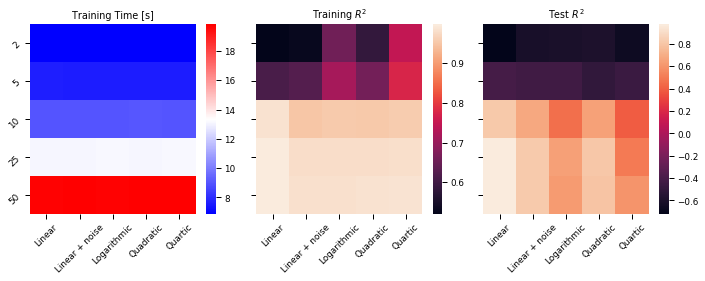

In [70]:
sns.set_context('paper', rc = {'Sans-Serif':'Helvetica-Neue'})

fig, ax = plt.subplots(1, 3, figsize = (10, 4))

Number_of_PCs = ["2", '5', '10', '25', '50']
FEA_Result = ["Linear", "Linear + noise", "Logarithmic",
           "Quadratic", "Quartic"]

sns.heatmap(results_time, ax = ax[0], cmap = 'bwr')
sns.heatmap(results_train_r2, ax = ax[1])
sns.heatmap(results_test_r2, ax = ax[2])



ax[0].set_xticklabels(labels = FEA_Result, rotation = 45)
ax[1].set_xticklabels(labels = FEA_Result, rotation = 45)
ax[2].set_xticklabels(labels = FEA_Result, rotation = 45)



ax[0].set_yticklabels(labels = Number_of_PCs, rotation = 45)
plt.setp(ax[1].get_yticklabels(), visible=False)
plt.setp(ax[2].get_yticklabels(), visible=False)

ax[0].set_title('Training Time [s]')
ax[1].set_title('Training $R^2$')
ax[2].set_title('Test $R^2$')


plt.tight_layout()

plt.savefig('ML_results_pd.jpeg', dpi = 600)

# __Part 3__
## Generating composites - bimodal distribution

In [71]:
def bimodal_distribution(mu_1, mu_2, sigma_1, sigma_2):
    '''
    This function generates a number from one of two bimodal distributions
    '''
    toss = np.random.choice((0, 1))
    
    if toss == 0:
        value = np.random.normal(mu_1, sigma_1, 1)
    else:
        value = np.random.normal(mu_2, sigma_2, 1)
    return np.asscalar(np.absolute(value.astype(int)))

In [72]:
bimodal_distribution(30, 60, 5, 15)

29

In [73]:
#number of cross-sections generated per fill ratio
n = 400

# This is the fractional fill ratio of fiber in the composite
fill_list = [0.1, 0.2, 0.30, 0.40, 0.50]

#Generate empty array for composite cross-sections
output_images = np.empty((400, 400, n*len(fill_list)))

m =0

for a, f in enumerate(fill_list):
    
    for i in range(n):
        t1 = time.time()
        #temporary array to populate with circles
        base = np.zeros([400, 400])
                
        # code borrow and modified from
        # https://stackoverflow.com/questions/46702987/python-pygame-randomly-draw-non-overlapping-circles?noredirect=1&lq=1

        class circle_class():
            def __init__(self):
                self.x = np.random.randint(0,base.shape[0])
                self.y = np.random.randint(0,base.shape[1])
                self.r = bimodal_distribution(30, 60, 5, 15)

            def new(self):
                #draws a circle of value 1 on the empty array
                cv.circle(base, (self.x, self.y), self.r, color = 1, thickness = -1)


        circles = []
        area_circle = 0
        
        '''
        The big change is that since there is a distribution, lots of really small circles could be generated, meeting the number of circles requirement, but not the area requirement
        So the while condition is changed from number to area
        
        '''
        while area_circle < f:
            # Draw a new circle
            new = circle_class()
            
            #keeps making new circles until the condition below is violated
            if any(pow(c.r - new.r, 2) <= \
                   pow(c.x - new.x, 2) + pow(c.y - new.y, 2) <= \
                   pow(c.r + new.r, 2) \
                for c in circles):

                    continue
            
            circles.append(new)
            new.new()
            
            area_circle = base.sum()/160000
            
        t2 = time.time()
        #print('Time per loop [ms] %.2f:' %((t2 - t1)*1000))
        
        #populate output array with temporary array
        output_images[:, :, m] = base
        
        m += 1

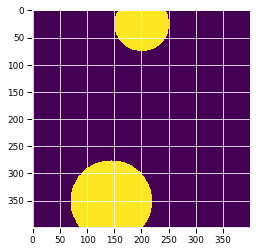

In [74]:
plt.imshow(output_images[:, :, 2])

# __Part 3__
## 2-point correlation function

In [75]:
t1 = time.time()
#Set up correlation function
p_basis = PrimitiveBasis(n_states=2, domain=[0, 1])
#set up output array
corr_images = np.empty((400, 400, n*len(fill_list)))

#add a new axis to the output images array to make the correlation function happy
input_array = output_images[np.newaxis, :, :, :]

#feed input array through correlate function, select the first element of axis 3, which is the fiber to fiber correlation
for i in range(n*len(fill_list)): 
    
    corr_images[:, :, i] = correlate(input_array[:, :, :, i], p_basis, periodic_axes = [0, 1])[0, :, :, 0]
t2 = time.time()
print('Time per step [ms] %.2f:' %((t2 - t1)*1000))

Time per step [ms] 123130.41:


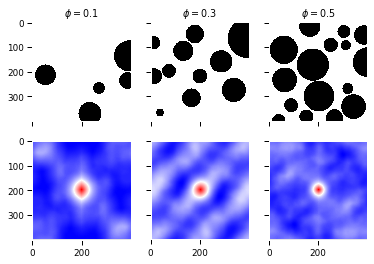

In [76]:
# figure 1
'''
Plot several fiber cross sections
'''
fig, ax = plt.subplots(2,3)

ax1 = plt.subplot(231, sharey=ax4)
plt.imshow(output_images[:, :, 1], cmap = 'Greys')
plt.setp(ax1.get_xticklabels(), visible=False)
ax1.grid(False)

# share x and y
ax2 = plt.subplot(232, sharey=ax4, sharex = ax1)
plt.imshow(output_images[:, :, 801], cmap = 'Greys')
plt.setp(ax2.get_xticklabels(), visible=False)
plt.setp(ax2.get_yticklabels(), visible=False)
ax2.grid(False)

# share x and y
ax3 = plt.subplot(233, sharey=ax4, sharex = ax1)
plt.imshow(output_images[:, :, 1601], cmap = 'Greys')
plt.setp(ax3.get_xticklabels(), visible=False)
plt.setp(ax3.get_yticklabels(), visible=False)
ax3.grid(False)

ax4 = plt.subplot(234)
plt.imshow(corr_images[:, :, 1], cmap = 'bwr')
ax4.grid(False)

# share x and y
ax5 = plt.subplot(235, sharey=ax4, sharex = ax1)
plt.imshow(corr_images[:, :, 801], cmap = 'bwr')
plt.setp(ax5.get_yticklabels(), visible=False)
ax5.grid(False)

# share x and y
ax6 = plt.subplot(236, sharey=ax4, sharex = ax1)
plt.imshow(corr_images[:, :, 1601], cmap = 'bwr')
plt.setp(ax6.get_yticklabels(), visible=False)
ax6.grid(False)


ax1.set_title('$\phi =0.1$')
ax2.set_title('$\phi =0.3$')
ax3.set_title('$\phi =0.5$')

plt.savefig('fibers_2point_bm.jpeg', dpi = 600)

# __Part 3__
## Flatten image stack and reshape

In [77]:
'''
order F is fortan order with first index changing the fastest, since index 2 is image number, it should change last.


''' 
t1 = time.time()
X_data = np.reshape(corr_images, (n*len(fill_list), 160000), order = 'F')
t2 = time.time()

print('Time per step [ms] %.2f:' %((t2 - t1)*1000))

Time per step [ms] 4208.27:


# __Part 3__
## Generate Pseudo-FEA Data

In [78]:
t1 = time.time()

#initialize list
y = np.empty((X_data.shape[0], 6))

#fill list with mean values
for i in range(n*len(fill_list)):
    
    # convert mean fill % to E sub 22 values in GPa
    y[i, 0] = output_images[:, :, i].mean()*20
   
    # generate noise
    y[i, 1] = np.random.normal(0, 1)

# Combine noise and percent fill together
y[:, 2] = y[:, 0] + y[:, 1]

# add underlying trends
#log
y[:, 3] = np.absolute(np.log(y[:, 2]*10)*10)

#quadratic
y[:, 4] = -(y[:, 2])*(y[:, 2]-2)*20

#quartic
y[:, 5] = -70*y[:, 2]*(y[:, 2]-1.1)*((y[:, 2]+0.2))*(y[:, 2]+0.4)**2

#clean up possible nan values from the log function
y = np.nan_to_num(y, nan = 0)

t2 = time.time()

print('Time per step [ms] %.2f:' %((t2 - t1)*1000))

Time per step [ms] 2618.85:


# __Part 3__
## PCA, Train/test split/ ML

In [79]:
n_PC = [2, 5, 10, 25, 50]
FEA_models = [0, 2, 3, 4, 5]

results_time = np.zeros((5, 5))
results_train_MAE = np.zeros((5, 5))
results_test_MAE = np.zeros((5, 5))

results_train_r2 = np.zeros((5, 5))
results_test_r2 = np.zeros((5, 5))


for b, PCs in enumerate(n_PC):
    t1 = time.time()
    
    '''
    perform PCA on n components and fit the x data to this
    
    '''
    x_pca = PCA(n_components = PCs).fit_transform(X_data)
    
    t2 = time.time()
    for a, model in enumerate(FEA_models):
        t3 = time.time()
        print(b, a)    
        #select one column
        y_vars = y[:, model]

        #train/test split
        x_train_pca, x_test_pca, y_train, y_test = train_test_split(x_pca, y_vars, test_size = 0.25)
             
        
        print('time for PCA', (t2-t1))
        
        #define model and fit data. These parameters are from the original paper
        params = {'n_estimators': 800,
          'max_depth': 3,
          'learning_rate': 0.1}
        
        reg = GradientBoostingRegressor(**params)
        reg.fit(x_train_pca, y_train)

               
        #get y_predictions
        y_train_pred = reg.predict(x_train_pca)
        y_test_pred = reg.predict(x_test_pca)
        
        #Time per loop
        t4 = time.time()
        
        
        #Save results    
        results_time[b, a] = (t2-t1 + t4-t3)
        
        results_train_MAE[b, a] = mean_absolute_error(y_train, y_train_pred)
        results_test_MAE[b, a] = mean_absolute_error(y_test, y_test_pred)
        
        results_train_r2[b, a] = r2_score(y_train, y_train_pred)
        results_test_r2[b, a] = r2_score(y_test, y_test_pred)
        
        
        '''
        For diagnostics, add a plot of the true vs predicted y values
        '''
        
        fig, ax = plt.subplots(1,2, figsize = (10, 4))

        sns.scatterplot(x = y_train, y = y_train_pred, ax = ax[0])
        sns.scatterplot(x = y_test, y = y_test_pred, ax = ax[1])

        ax[0].set_title('Y train vs Y Train Predicted')
        ax[1].set_title('Y test vs Y Test Predicted')

        ax[0].set_xlabel('FEA Predictions')
        ax[1].set_xlabel('FEA Predictions')

        ax[0].set_ylabel('ML Predictions')
        ax[1].set_ylabel('ML Predictions')
        
        plt.suptitle('N of PCs:'+str(PCs)+ ' | Underlying model:' + str(model) )

        plt.savefig('N of PCs'+str(PCs)+ '  Underlying model' + str(model)+'pd.jpeg')

        plt.close()

0 0
time for PCA 5.883306264877319
0 1
time for PCA 5.883306264877319
0 2
time for PCA 5.883306264877319
0 3
time for PCA 5.883306264877319
0 4
time for PCA 5.883306264877319
1 0
time for PCA 6.497028589248657
1 1
time for PCA 6.497028589248657
1 2
time for PCA 6.497028589248657
1 3
time for PCA 6.497028589248657
1 4
time for PCA 6.497028589248657
2 0
time for PCA 6.490356206893921
2 1
time for PCA 6.490356206893921
2 2
time for PCA 6.490356206893921
2 3
time for PCA 6.490356206893921
2 4
time for PCA 6.490356206893921
3 0
time for PCA 7.942834377288818
3 1
time for PCA 7.942834377288818
3 2
time for PCA 7.942834377288818
3 3
time for PCA 7.942834377288818
3 4
time for PCA 7.942834377288818
4 0
time for PCA 8.860045433044434
4 1
time for PCA 8.860045433044434
4 2
time for PCA 8.860045433044434
4 3
time for PCA 8.860045433044434
4 4
time for PCA 8.860045433044434


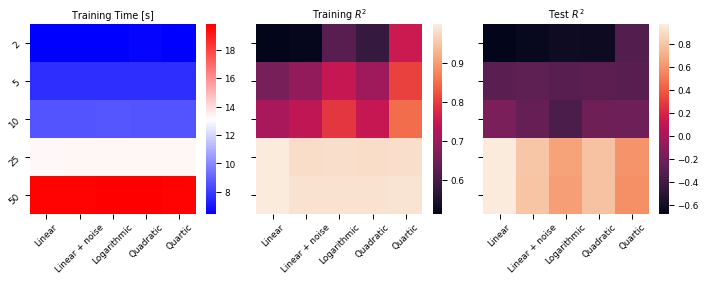

In [80]:
sns.set_context('paper', rc = {'Sans-Serif':'Helvetica-Neue'})

fig, ax = plt.subplots(1, 3, figsize = (10, 4))

Number_of_PCs = ["2", '5', '10', '25', '50']
FEA_Result = ["Linear", "Linear + noise", "Logarithmic",
           "Quadratic", "Quartic"]

sns.heatmap(results_time, ax = ax[0], cmap = 'bwr')
sns.heatmap(results_train_r2, ax = ax[1])
sns.heatmap(results_test_r2, ax = ax[2])



ax[0].set_xticklabels(labels = FEA_Result, rotation = 45)
ax[1].set_xticklabels(labels = FEA_Result, rotation = 45)
ax[2].set_xticklabels(labels = FEA_Result, rotation = 45)



ax[0].set_yticklabels(labels = Number_of_PCs, rotation = 45)
plt.setp(ax[1].get_yticklabels(), visible=False)
plt.setp(ax[2].get_yticklabels(), visible=False)

ax[0].set_title('Training Time [s]')
ax[1].set_title('Training $R^2$')
ax[2].set_title('Test $R^2$')


plt.tight_layout()
plt.savefig('ML results_bm.jpeg', dpi = 600)

In [81]:
results_test_r2

array([[-0.67920048, -0.64447331, -0.62102597, -0.62273798, -0.33111918],
       [-0.2901074 , -0.27796763, -0.29425204, -0.28390882, -0.30496678],
       [-0.17008655, -0.24408646, -0.3510478 , -0.22137   , -0.21353279],
       [ 0.96977466,  0.80786879,  0.66162705,  0.79466092,  0.6048506 ],
       [ 0.96498455,  0.79590227,  0.6427024 ,  0.79334123,  0.58958716]])